In [222]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import joblib

# Reading The Dataset 

In [223]:
df = pd.read_csv("D:\\Project\\new_projects\\Anomaly_Detection\\financial_anomaly_data.csv")

In [224]:
df.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217441 entries, 0 to 217440
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Timestamp        216960 non-null  object 
 1   TransactionID    216960 non-null  object 
 2   AccountID        216960 non-null  object 
 3   Amount           216960 non-null  float64
 4   Merchant         216960 non-null  object 
 5   TransactionType  216960 non-null  object 
 6   Location         216960 non-null  object 
dtypes: float64(1), object(6)
memory usage: 11.6+ MB


# Feature Engineering 

In [226]:
# Separate Timestamp into date and time components
df['Date'] = pd.to_datetime(df['Timestamp']).dt.date
df['Time'] = pd.to_datetime(df['Timestamp']).dt.time

# Extract suffixes for TransactionID, AccountID, and Merchant
df['TransactionID_Suffix'] = df['TransactionID'].str[3:]
df['AccountID_Suffix'] = df['AccountID'].str[3:]
df['Merchant_Suffix'] = df['Merchant'].str[8:]

# Drop original columns if needed
df.drop(columns=['Timestamp', 'TransactionID', 'AccountID', 'Merchant'], inplace=True)

# Display the DataFrame with new columns
df.head(10)


,Amount,TransactionType,Location,Date,Time,TransactionID_Suffix,AccountID_Suffix,Merchant_Suffix
0,95071.92,Purchase,Tokyo,2023-01-01,08:00:00,1127,4,H
1,15607.89,Purchase,London,2023-01-01,08:01:00,1639,10,H
2,65092.34,Withdrawal,London,2023-01-01,08:02:00,872,8,E
3,87.87,Purchase,London,2023-01-01,08:03:00,1438,6,E
4,716.56,Purchase,Los Angeles,2023-01-01,08:04:00,1338,6,I
5,13957.99,Transfer,London,2023-01-01,08:05:00,1083,15,C
6,4654.58,Transfer,Tokyo,2023-01-01,08:06:00,832,9,C
7,1336.36,Withdrawal,San Francisco,2023-01-01,08:07:00,841,7,I
8,9776.23,Transfer,London,2023-01-01,08:08:00,777,10,D
9,49522.74,Withdrawal,New York,2023-01-01,08:09:00,1479,12,C


In [227]:
# Rename columns
df.rename(columns={'TransactionID_Suffix': 'TransactionID', 
                   'AccountID_Suffix': 'AccountID', 
                   'Merchant_Suffix': 'Merchant'}, inplace=True)

# Display the DataFrame with renamed columns
df.head()

,Amount,TransactionType,Location,Date,Time,TransactionID,AccountID,Merchant
0,95071.92,Purchase,Tokyo,2023-01-01,08:00:00,1127,4,H
1,15607.89,Purchase,London,2023-01-01,08:01:00,1639,10,H
2,65092.34,Withdrawal,London,2023-01-01,08:02:00,872,8,E
3,87.87,Purchase,London,2023-01-01,08:03:00,1438,6,E
4,716.56,Purchase,Los Angeles,2023-01-01,08:04:00,1338,6,I


# Observation : 
 In preprocessing our dataset, we simplified it by extracting relevant information and removing constant suffixes. We separated the Timestamp column into Date and Time components, providing a clearer representation of temporal data. Additionally, we extracted meaningful information from columns like TransactionID, AccountID, and Merchant by removing consistent prefixes, which simplified the data while retaining its integrity. This preprocessing step improves the dataset's usability for further analysis and machine learning model development, as it reduces noise and ensures consistency in feature representation.

In [228]:
null_values = df.isnull().sum()
print(null_values)

Amount             481
TransactionType    481
Location           481
Date               481
Time               481
TransactionID      481
AccountID          481
Merchant           481
dtype: int64


In [229]:
df['Amount'].fillna(df['Amount'].mean(), inplace=True)

In [230]:
for column in ['TransactionType', 'Location', 'Date', 'Time', 'TransactionID', 'AccountID', 'Merchant']:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [231]:
df.isnull().sum()

Amount             0
TransactionType    0
Location           0
Date               0
Time               0
TransactionID      0
AccountID          0
Merchant           0
dtype: int64

# Data Visualization 

## Statistical Methods 
### Exploring Amount  

In [232]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime format
df['Month'] = df['Date'].dt.month  # Extract month from 'Date' column

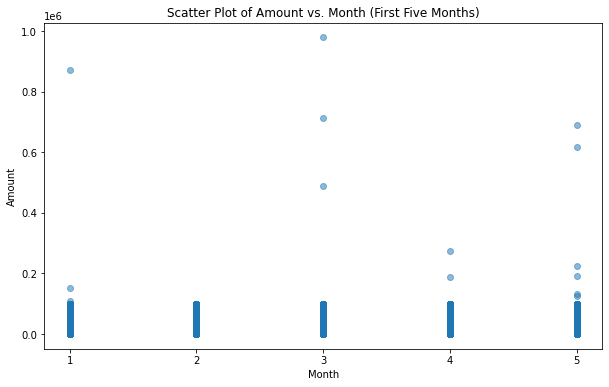

In [233]:
# Filter the DataFrame for data points in the first five months
outliers_df = df[df['Month'] <= 5]

# Scatter plot of 'Amount' against 'Month' for outliers
plt.figure(figsize=(10, 6))
plt.scatter(outliers_df['Month'], outliers_df['Amount'], alpha=0.5)
plt.title('Scatter Plot of Amount vs. Month (First Five Months)')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.xticks(range(1, 6))  # Set x-axis ticks to represent months from 1 to 5
plt.show()

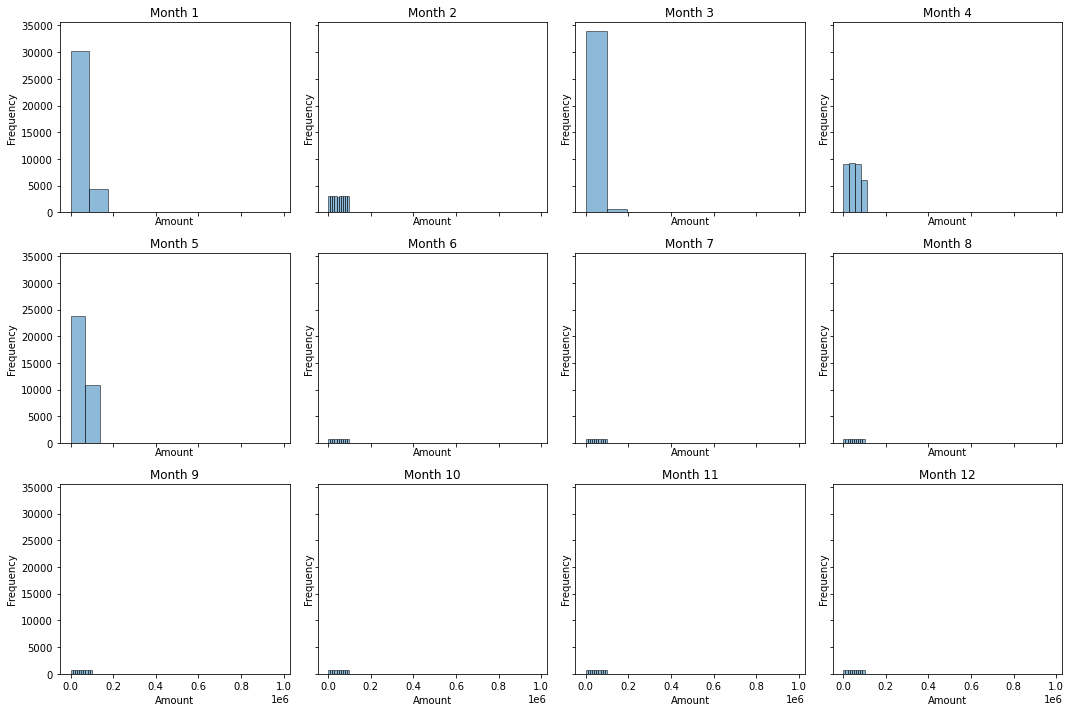

In [234]:
# Define the number of bins
num_bins = 10

# Create subplots for each month
fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axes array
axes = axes.flatten()

# Iterate over each month
for i, (name, group) in enumerate(df.groupby('Month')):
    ax = axes[i]
    ax.hist(group['Amount'], bins=num_bins, alpha=0.5, label=f'Month {name}', edgecolor='black')
    ax.set_title(f'Month {name}')
    ax.set_xlabel('Amount')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [235]:
# Calculate the maximum amount for each month
max_amounts = df.groupby('Month')['Amount'].max()

# Calculate the average maximum amount across the months
average_max_amount = max_amounts.mean()

print(f"The average maximum amount across the months is: {average_max_amount}")

The average maximum amount across the months is: 301188.0433333334


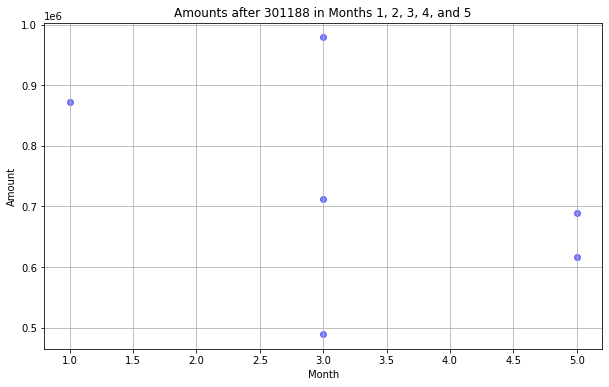

In [236]:
# Define the months and the threshold amount
months_of_interest = [1, 2, 3, 4, 5]
threshold_amount = 301188

# Filter the DataFrame for the specified months and amounts greater than the threshold
filtered_data = df[(df['Month'].isin(months_of_interest)) & (df['Amount'] > threshold_amount)]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Month'], filtered_data['Amount'], color='blue', alpha=0.5)
plt.title('Amounts after 301188 in Months 1, 2, 3, 4, and 5')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

In [237]:
# Calculate the maximum amount for each month
max_amounts = df.groupby('Month')['Amount'].max()
# Calculate the maximum amount for each month
min_amounts = df.groupby('Month')['Amount'].min()

# Calculate the average maximum amount across the months
average_max_amount = max_amounts.mean()
# Calculate the average maximum amount across the months
average_min_amount = min_amounts.mean()

print(f"The average maximum amount across the months is: {average_max_amount}")
print(f"The average maximum amount across the months is: {average_min_amount}")

The average maximum amount across the months is: 301188.0433333334
The average maximum amount across the months is: 14.5725


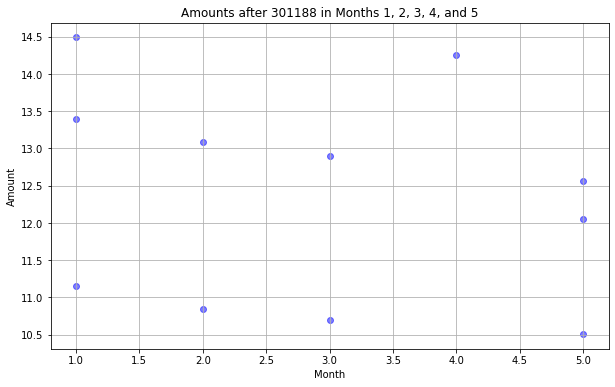

In [238]:
# Define the months and the threshold amount
months_of_interest = [1, 2, 3, 4, 5]
threshold_amount = 14.5725

# Filter the DataFrame for the specified months and amounts greater than the threshold
filtered_data = df[(df['Month'].isin(months_of_interest)) & (df['Amount'] < threshold_amount)]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Month'], filtered_data['Amount'], color='blue', alpha=0.5)
plt.title('Amounts after 301188 in Months 1, 2, 3, 4, and 5')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

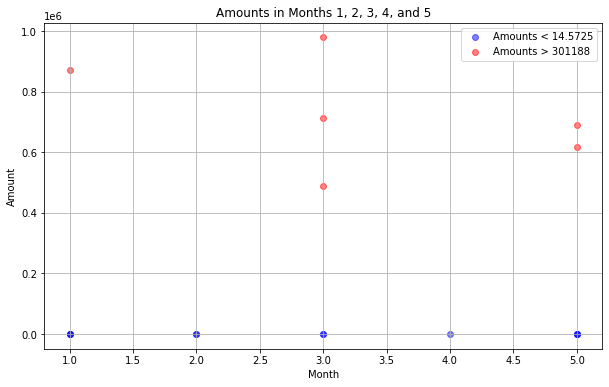

In [239]:
# Define the months and the threshold amounts
threshold_amount_low = 14.5725
threshold_amount_high = 301188

# Filter the DataFrame for the specified months and amounts greater than the low threshold
filtered_data_low = df[(df['Month'].isin(months_of_interest)) & (df['Amount'] < threshold_amount_low)]

# Filter the DataFrame for the specified months and amounts greater than the high threshold
filtered_data_high = df[(df['Month'].isin(months_of_interest)) & (df['Amount'] > threshold_amount_high)]

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot points below the low threshold
plt.scatter(filtered_data_low['Month'], filtered_data_low['Amount'], color='blue', alpha=0.5, label='Amounts < 14.5725')

# Plot points above the high threshold
plt.scatter(filtered_data_high['Month'], filtered_data_high['Amount'], color='red', alpha=0.5, label='Amounts > 301188')

plt.title('Amounts in Months 1, 2, 3, 4, and 5')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()


# Observation: 
These blue points can possiblity be a lower level anamolies in terms of Amount with respet to the months in the data is been recorded and the red ones can be the same from a higher level. 

### Exploring amount with Account ID (AccountID)

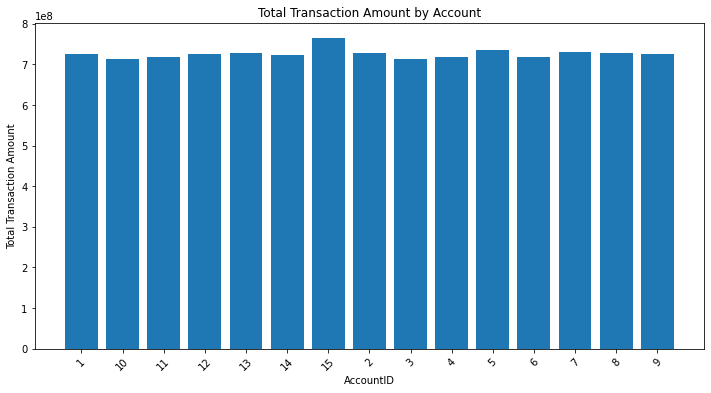

In [240]:
# Group transactions by AccountID and calculate the total transaction amount for each account
account_amount = df.groupby('AccountID')['Amount'].sum()

# Plot AccountID against the Amount of transactions
plt.figure(figsize=(12, 6))
plt.bar(account_amount.index, account_amount.values)
plt.title('Total Transaction Amount by Account')
plt.xlabel('AccountID')
plt.ylabel('Total Transaction Amount')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


### Exploring amount with Type of Transaction (Transactiontype)

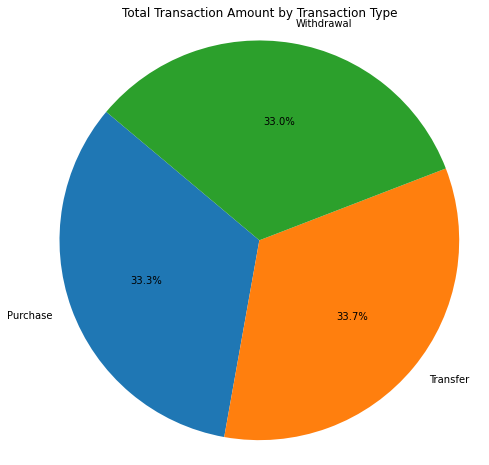

In [241]:

# Assuming your DataFrame is named 'df'

# Group transactions by TransactionType and calculate the total transaction amount for each type
transaction_type_amount = df.groupby('TransactionType')['Amount'].sum()

# Plot a pie chart of the total transaction amount by transaction type
plt.figure(figsize=(8, 8))
plt.pie(transaction_type_amount.values, labels=transaction_type_amount.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Transaction Amount by Transaction Type')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Exploring amount with Type of Merchant Type (Merchant)

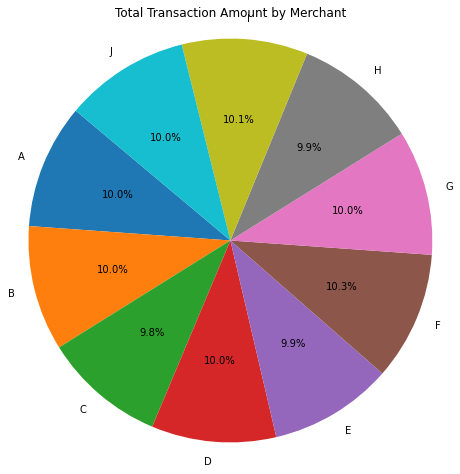

In [242]:
# Group transactions by Merchant and calculate the total transaction amount for each merchant
merchant_amount = df.groupby('Merchant')['Amount'].sum()

# Plot a pie chart of the total transaction amount by merchant
plt.figure(figsize=(8, 8))
plt.pie(merchant_amount.values, labels=merchant_amount.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Transaction Amount by Merchant')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [243]:
df['Date'] = pd.to_datetime(df['Date'])
# Extract day from the 'Date' column and create a new column
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year


In [244]:
# Get all unique values in the 'Day' column and sort them
sorted_unique_days = sorted(df['Day'].unique())
print("Sorted unique values in the Day column:")
print(sorted_unique_days)

Sorted unique values in the Day column:
[1, 2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [245]:
df.head() 

,Amount,TransactionType,Location,Date,Time,TransactionID,AccountID,Merchant,Month,Day,Year
0,95071.92,Purchase,Tokyo,2023-01-01,08:00:00,1127,4,H,1,1,2023
1,15607.89,Purchase,London,2023-01-01,08:01:00,1639,10,H,1,1,2023
2,65092.34,Withdrawal,London,2023-01-01,08:02:00,872,8,E,1,1,2023
3,87.87,Purchase,London,2023-01-01,08:03:00,1438,6,E,1,1,2023
4,716.56,Purchase,Los Angeles,2023-01-01,08:04:00,1338,6,I,1,1,2023


In [246]:
df.drop(columns=['Date'], inplace=True) 

In [247]:
df.head()

,Amount,TransactionType,Location,Time,TransactionID,AccountID,Merchant,Month,Day,Year
0,95071.92,Purchase,Tokyo,08:00:00,1127,4,H,1,1,2023
1,15607.89,Purchase,London,08:01:00,1639,10,H,1,1,2023
2,65092.34,Withdrawal,London,08:02:00,872,8,E,1,1,2023
3,87.87,Purchase,London,08:03:00,1438,6,E,1,1,2023
4,716.56,Purchase,Los Angeles,08:04:00,1338,6,I,1,1,2023


### Exploring Amount with Date (Date)

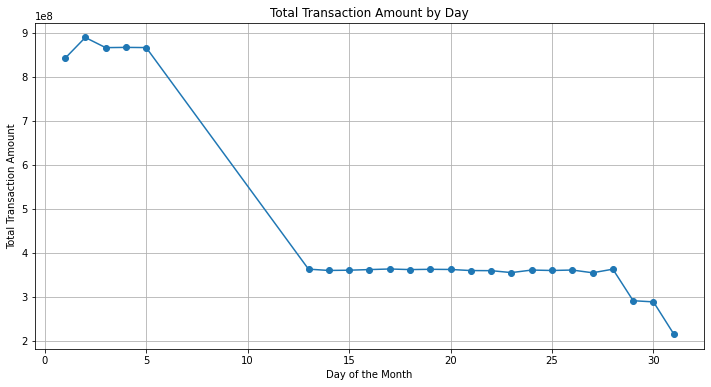

In [248]:
# Group transactions by day and calculate the total transaction amount for each day
day_amount = df.groupby('Day')['Amount'].sum()

# Plot amount against the day
plt.figure(figsize=(12, 6))
plt.plot(day_amount.index, day_amount.values, marker='o')
plt.title('Total Transaction Amount by Day')
plt.xlabel('Day of the Month')
plt.ylabel('Total Transaction Amount')
plt.grid(True)
plt.show()

# Observation:
we can see a weird distribution where the amount stays constant between approximate 12th to 26th of every month wheres there are no transactions between 5th o 12th but from 1st and 5th there are high amount transactions happening. 

### Exploring Amount with location (Location)

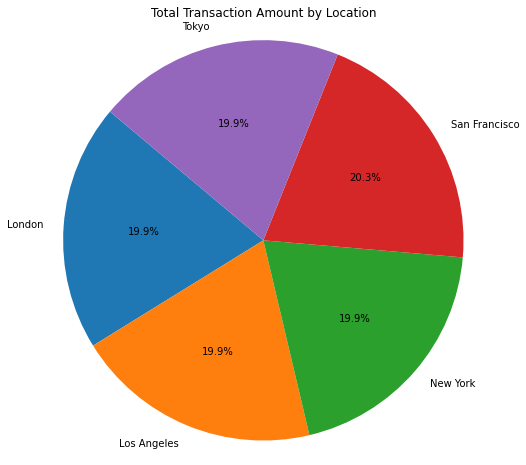

In [249]:
# Group transactions by location and calculate the total transaction amount for each location
location_amount = df.groupby('Location')['Amount'].sum()

# Plot a pie chart of the total transaction amount by location
plt.figure(figsize=(8, 8))
plt.pie(location_amount.values, labels=location_amount.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Transaction Amount by Location')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Observations:
As we can see where from all places San Francisco shows 0.4 % more transactions 

# Model Selection or procedure to decide how to find the Anomalies 

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217441 entries, 0 to 217440
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Amount           217441 non-null  float64
 1   TransactionType  217441 non-null  object 
 2   Location         217441 non-null  object 
 3   Time             217441 non-null  object 
 4   TransactionID    217441 non-null  object 
 5   AccountID        217441 non-null  object 
 6   Merchant         217441 non-null  object 
 7   Month            217441 non-null  int64  
 8   Day              217441 non-null  int64  
 9   Year             217441 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 16.6+ MB


# Isolation Forest  
with one hot encoder 

In [251]:
# Using all features except 'TransactionID' and 'AccountID' for anomaly detection
selected_features = ['Amount', 'TransactionType', 'Location', 'Merchant', 'Month', 'Day', 'Year']

X = df[selected_features]


# Convert 'Time' column to hour of the day
def extract_hour(time):
    return time.hour

X['Hour'] = X['Time'].apply(extract_hour)
X.drop('Time', axis=1, inplace=True)

# One-Hot Encoding for Categorical Variables
categorical_features = ['TransactionType', 'Location', 'Merchant']
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

X_encoded = preprocessor.fit_transform(X)

#  Train-Test Split
X_train, X_test = train_test_split(X_encoded, test_size=0.2, random_state=42)

# Adjust contamination based on the proportion of outliers in the dataset


#  Model Selection and Training
model = IsolationForest(contamination=0.01, random_state=42)  # we can Adjust contamination based on expected anomaly rate
model.fit(X_train)

# Model Evaluation
predictions = model.predict(X_test)
print(classification_report(predictions, [-1 if p == -1 else 1 for p in predictions]))  # Labels are -1 for anomalies and 1 for normal instances

# Determine Threshold (Optional)

# Anomaly Detection
anomaly_scores = model.decision_function(X_encoded)  # The lower the score, the more abnormal the instance



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12884\3439564840.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Hour'] = X['Time'].apply(extract_hour)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12884\3439564840.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('Time', axis=1, inplace=True)


              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       470
           1       1.00      1.00      1.00     43019

    accuracy                           1.00     43489
   macro avg       1.00      1.00      1.00     43489
weighted avg       1.00      1.00      1.00     43489



# Analyzing Detected Anomalies

In [252]:
 
anomaly_indices = [index for index, prediction in enumerate(predictions) if prediction == -1]
anomalies = X.iloc[anomaly_indices]

# 1. Identifying Anomalies
print("Detected Anomalies:")
anomalies

Detected Anomalies:


,Amount,TransactionType,Location,Merchant,Month,Day,Year,Hour
15,98688.82,Purchase,London,H,1,1,2023,8
103,37632.20,Purchase,London,C,1,1,2023,9
246,33.75,Transfer,Los Angeles,B,1,1,2023,12
345,86891.37,Withdrawal,New York,A,1,1,2023,13
475,2213.30,Transfer,San Francisco,E,1,1,2023,15
...,...,...,...,...,...,...,...,...
42876,94256.05,Withdrawal,New York,E,1,31,2023,2
43238,35322.97,Withdrawal,London,B,1,31,2023,8
43324,59074.05,Purchase,San Francisco,I,1,31,2023,10
43360,7543.98,Purchase,London,B,1,31,2023,10


In [253]:
# 2. Analyze Features
# Example: Investigate the distribution of transaction amounts for anomalies
anomaly_amounts = anomalies['Amount']
print("Anomaly Amounts Summary:")
print(anomaly_amounts.describe())

Anomaly Amounts Summary:
count      470.000000
mean     50433.884362
std      29258.770480
min         33.750000
25%      24929.570000
50%      50794.815000
75%      74649.120000
max      99857.900000
Name: Amount, dtype: float64


In [254]:
#  Compare with Normal Instances
normal_indices = [index for index, prediction in enumerate(predictions) if prediction == 1]
normal_instances = X.iloc[normal_indices]

#  Evaluate False Positives
# Example: Check for instances misclassified as anomalies
false_positives = [index for index, prediction in enumerate(predictions) if prediction == -1 and index not in anomaly_indices]
print("False Positives:")
print(X.iloc[false_positives])

False Positives:
Empty DataFrame
Columns: [Amount, TransactionType, Location, Merchant, Month, Day, Year, Hour]
Index: []


# Iterative Refinement

In [255]:
# Example: Adjusting contamination based on false positives rate
false_positive_rate = len(false_positives) / len(predictions)
print("False Positive Rate:", false_positive_rate)

# Adjusting contamination if necessary
if false_positive_rate > 0.001:
    model = IsolationForest(contamination=false_positive_rate, random_state=42)
    model.fit(X_train)

False Positive Rate: 0.0


# Saving the model 

In [256]:


# Save the trained model
joblib.dump(model, 'isolation_forest_model.pkl')




['isolation_forest_model.pkl']